## Preparing the Environment

In [31]:
from __future__ import print_function
import numpy as np
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from ifqi import envs
from ifqi.evaluation import evaluation
from ifqi.algorithms.fqi.FQI import FQI

%matplotlib notebook

In [2]:
mdp = envs.LQG1D()
state_dim, action_dim, reward_dim = envs.get_space_info(mdp)
reward_idx = state_dim + action_dim
discrete_actions = np.array([-8, -7, -6, -5, -4, -3, -2.5, -2, -1.5, -1, -.75,
                             -.5, -.25, 0, .25, .5, .75, 1, 1.5, 2, 2.5, 3, 4,
                             5, 6, 7, 8])

dataset = evaluation.collect_episodes(mdp, n_episodes=1000)
sast = np.append(dataset[:, :reward_idx],
                 dataset[:, reward_idx + reward_dim:-1],
                 axis=1)
r = dataset[:, reward_idx]

## Learning with FQI and `LinearRegression`

In [16]:
class Regressor:
    __slots__ = ('b', 'k')
    
    def __init__(self, b=0, k=0):
        self.b = b
        self.k = k
    
    def fit(self, X, y):
        #print("fitting: ", end='')
        (self.b, self.k), pcov = curve_fit(self.Q, X, y)
        #print(self.b, self.k)
    
    def Q(self, sa, b, k):
        return b - (sa[:, 1] - k *  sa[:, 0]) ** 2
    
    def predict(self, X):
        return self.Q(X, self.b, self.k)

regressor = Regressor()
regressor = Pipeline([('poly', PolynomialFeatures(degree=2)),
                      ('linear', LinearRegression(fit_intercept=False))])

In [17]:
fqi = FQI(estimator=regressor,
          state_dim=state_dim,
          action_dim=action_dim,
          discrete_actions=discrete_actions,
          gamma=mdp.gamma,
          horizon=mdp.horizon,
          features=None,
          verbose=False)

In [18]:
fqi._verbose

False

In [19]:
fqi.fit(sast, r)

In [20]:
initial_states = np.array([[1, 2, 5, 7, 10]]).T

In [21]:
values = evaluation.evaluate_policy(mdp, fqi, initial_states=initial_states)
print("values (mean {:06.2f}, se {:06.2f})\n steps (mean {:06.2f}, se {:06.2f})".format(*values))

values (mean -63.83, se 050.21)
 steps (mean 100.00, se 000.00)


## Evaluating the Optimal Policy

In [11]:
K = mdp.computeOptimalK()[0][0]
K

-0.61525124566301148

In [12]:
class OptimalPolicy:
    
    def draw_action(self, states, absorbing, evaluation=False):
        i = np.abs(discrete_actions - K*states).argmin()
        #print("states: {} action: {}".format(states, discrete_actions[i]))
        return discrete_actions[i]
    
optimalP = OptimalPolicy()


In [13]:
values = evaluation.evaluate_policy(mdp, optimalP, initial_states=initial_states)
print("values (mean {:8.2f}, se {:8.2f})\n steps (mean {:8.2f}, se {:8.2f})".format(*values))

values (mean   -53.55, se    47.31)
 steps (mean   100.00, se     0.00)


## Comparing Optimal Q to fitted-Q

In [57]:
# Compute optimal Q
K = mdp.computeOptimalK()
S = 0.001  # covariance of the controller
Q = np.empty((50*50,3))
i = 0
for x in np.linspace(-10, 10, 50):
    for a in np.linspace(-8, 8, 50):
        v = mdp.computeQFunction(x, a, K, S, 100)
        Q[i] = (x, a, v)
        i += 1

In [58]:
pred = regressor.predict(Q[:,0:2])

<IPython.core.display.Javascript object>


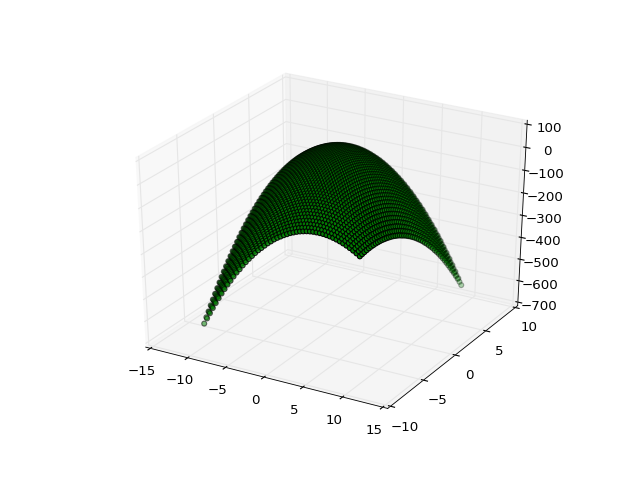

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Q[:, 0], Q[:, 1], Q[:, 2], c='g', marker='o')

<IPython.core.display.Javascript object>


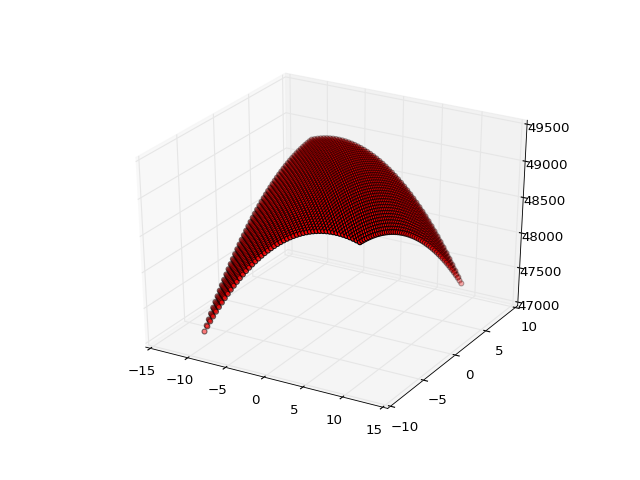

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Q[:, 0], Q[:, 1], pred, c='r', marker='o')

In [61]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(Q[:, 2], pred)
mae

48834.813024323608

<IPython.core.display.Javascript object>


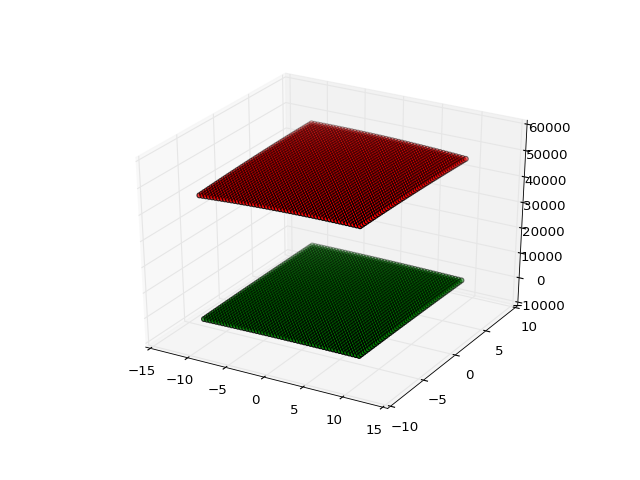

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Q[:, 0], Q[:, 1], Q[:, 2], c='g', marker='o')
ax.scatter(Q[:, 0], Q[:, 1], pred, c='r', marker='o')

<IPython.core.display.Javascript object>


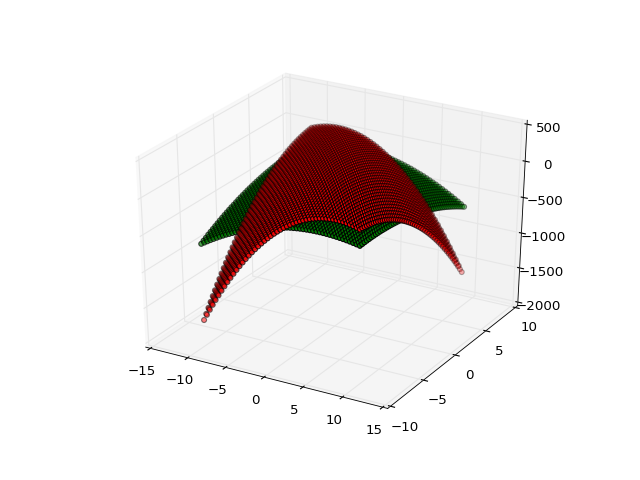

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Q[:, 0], Q[:, 1], Q[:, 2], c='g', marker='o')
ax.scatter(Q[:, 0], Q[:, 1], pred - mae, c='r', marker='o')